In [3]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
from collections import Counter
from anndata import AnnData
from scipy.sparse import issparse
from matplotlib.colors import Colormap, TwoSlopeNorm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sc.logging.print_header()
import os
import anndata as ad
os.chdir("/home/wyh/scdata/combined_data/Epithelial/")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
import cnmf
from IPython.display import Image

In [3]:
def scanpy_pipline(adata_obj,islog = False):
    if(not islog):
        sc.pp.normalize_total(adata_obj, target_sum=1e4)
        sc.pp.log1p(adata_obj)   
    sc.pp.highly_variable_genes(adata_obj, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_obj.raw = adata_obj
    adata_obj = adata_obj[:, adata_obj.var.highly_variable]
    sc.pp.scale(adata_obj, max_value=10)
    sc.tl.pca(adata_obj, svd_solver='arpack')
    sc.pp.neighbors(adata_obj, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(adata_obj)
    sc.tl.umap(adata_obj)
    adata_obj = adata_obj.raw.to_adata()
    return(adata_obj)

In [4]:
sc.settings.set_figure_params(figsize=(3, 3))

# NMF between adeno

In [3]:
import os
os.chdir("/home/wyh/scdata/combined_data/Epithelial/")
adata = sc.read_h5ad("./Epithelial_cnv.h5ad")

adata.uns['log1p']['base'] = None
adata = adata[adata.obs['cnv_status']=="tumor",]
adata_adeno = adata[adata.obs["histological.type.short"]=="adeno",:]
adata_adeno = adata_adeno[adata_adeno.obs["Tumors.for.scRNA.seq.short"]=="P",:]

adata_adeno.obs['metastasis.type'][adata_adeno.obs['metastasis.type']=="P_LI"] = "P"
adata_adeno.obs['metastasis.type'] = adata_adeno.obs['metastasis.type'].cat.remove_categories("P_LI")

adata_adeno.obs['metastasis.type'] = adata_adeno.obs['metastasis.type'].cat.reorder_categories(['P',"P_LN","P_LM"])


/tmp/ipykernel_35374/236667078.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_adeno.obs['metastasis.type'] = adata_adeno.obs['metastasis.type'].cat.remove_categories("P_LI")


In [49]:
Epithelial = sc.read_h5ad("/home/wyh/scdata/combined_data/Epithelial/Epithelial.h5ad")
adata_adeno.layers['counts'] = Epithelial[adata_adeno.obs_names,adata_adeno.var_names].X

In [45]:
adata_adeno = scanpy_pipline(adata_adeno,islog=True)

/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [52]:
adata_adeno.write("./adata_adeno_P.h5ad")

adata_adeno

In [4]:
import scanpy as sc

In [4]:
adata_adeno = sc.read_h5ad("./adata_adeno_P.h5ad")
adata_adeno.uns['log1p']['base'] = None

In [55]:
import multiprocessing
adata_obj = adata_adeno.copy()
data = adata_obj.X
connectivities = adata_obj.obsp['connectivities']
# adata_obj.raw = adata_obj
# 先过滤一部分表达量都为0的基因
def score_cal(igene):
    x_scale = sc.pp.scale(data[:,igene], zero_center=True, max_value=10)
    score_igene = (x_scale.transpose() @ connectivities @ x_scale)[0][0]
    #print(score_igene)
    return(score_igene)

cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)

score = pool.map(score_cal,range(len(adata_obj.var_names.values)))
pool.close()
pool.join()

#score = [score_cal(igene) for igene in range(10)] 
score = pd.Series(score,index = adata_obj.var_names.values)

score = score.sort_values(ascending = False)

In [75]:
pd.DataFrame(score.index.values[range(2000)]).to_csv("./NMFV2/adeno_P_HRG.csv",index = False,header = False)

In [59]:
def get_class_num(df,n):
    def get_num(x):
        if(len(x)>n):
            sampled_x = x.sample(n,random_state = 2022).reset_index(drop=True)
        else:
            sampled_x = x
        return(sampled_x)
            
    weighted_sample = df.groupby('orig.ident').apply(get_num)  
    return(weighted_sample) 

            
df = adata_adeno.obs
df['barcode'] = df.index
weighted_sample = get_class_num(df,500)


In [70]:
weighted_sample.to_csv("./NMFV2/temp.csv")

In [71]:
adata_adeno_sample = adata_adeno[weighted_sample["barcode"],]

In [77]:
adata_adeno_sample.write("./NMFV2/adata_adeno_p_sample.h5ad")

In [5]:
adata_adeno_sample = sc.read_h5ad("./NMFV2/adata_adeno_p_sample.h5ad")

In [11]:
# step1 prepare
basedir = "/home/wyh/scdata/combined_data/Epithelial"
output_directory = basedir+"/NMFV2/"
run_name = "Epithelial_adeno"
countfn = "/home/wyh/scdata/combined_data/Epithelial/NMFV2_new/adata_adeno_p_sample.h5ad"
K = ' '.join([str(i) for i in range(20,50)])
seed = 2022
numiter = 10
numworkers = 100
genes_file = basedir+"/NMFV2/adeno_P_HRG.csv"

prepare_cmd = '/home/wyh/anaconda3/envs/wuyh_py38/bin/python cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --genes-file %s --beta-loss frobenius' % (output_directory, run_name, countfn, K, numiter, numworkers, seed, genes_file)
print('Prepare command assuming parallelization with %d cores:\n%s' % (numworkers, prepare_cmd))
! {prepare_cmd}

Prepare command assuming parallelization with 100 cores:
/home/wyh/anaconda3/envs/wuyh_py38/bin/python cnmf.py prepare --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno -c /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/adata_adeno_p_sample.h5ad -k 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 --n-iter 10 --total-workers 100 --seed 2022 --genes-file /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/adeno_P_HRG.csv --beta-loss frobenius
(28162, 2000)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
import cnmf

In [13]:
"""## Submitting all of the factorization jobs for the 0th (I.e. the only) worker
factorize_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py factorize --output-dir %s --name %s --worker-index 0' % (output_directory, run_name)
print('Factorize command with no parallelization:\n%s' % factorize_cmd)
!{factorize_cmd}
"""
## Using GNU parallel
## This took 4 minutes in our testing
basedir = "/home/wyh/scdata/combined_data/Epithelial"
output_directory = basedir+"/NMFV2/"
worker_index = ' '.join([str(x) for x in range(numworkers)])
factorize_cmd = '/home/wyh/anaconda3/envs/wuyh_py38/bin/python %s/cnmf.py factorize --output-dir %s --name %s --worker-index %s --total-workers %d'
commands = []
for i in worker_index.split(' '):
    commands.append(factorize_cmd%(basedir, output_directory, run_name, i, numworkers))
commands = "\n".join(commands)
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, commands))

joblist = open("/home/wyh/scdata/combined_data/Epithelial/NMFV2_new/joblist", "w")
joblist.write(commands)
joblist.close()
!{commands}

Factorize command to simultaneously run factorization over 100 cores using GNU parallel:
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py factorize --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno --worker-index 0 --total-workers 100
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py factorize --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno --worker-index 1 --total-workers 100
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py factorize --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno --worker-index 2 --total-workers 100
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py factorize --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno --worker-index 3

In [14]:
# step2 combine
cmd = '/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print(cmd)
!{cmd}

/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py combine --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
C

## Figure: choose K number

K selection plot command: /home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py k_selection_plot --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2_new/ --name Epithelial_adeno
(28162, 2000)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
(28162, 2000)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
(28162, 2000)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
(28162, 2000)
/home/wyh/anacon

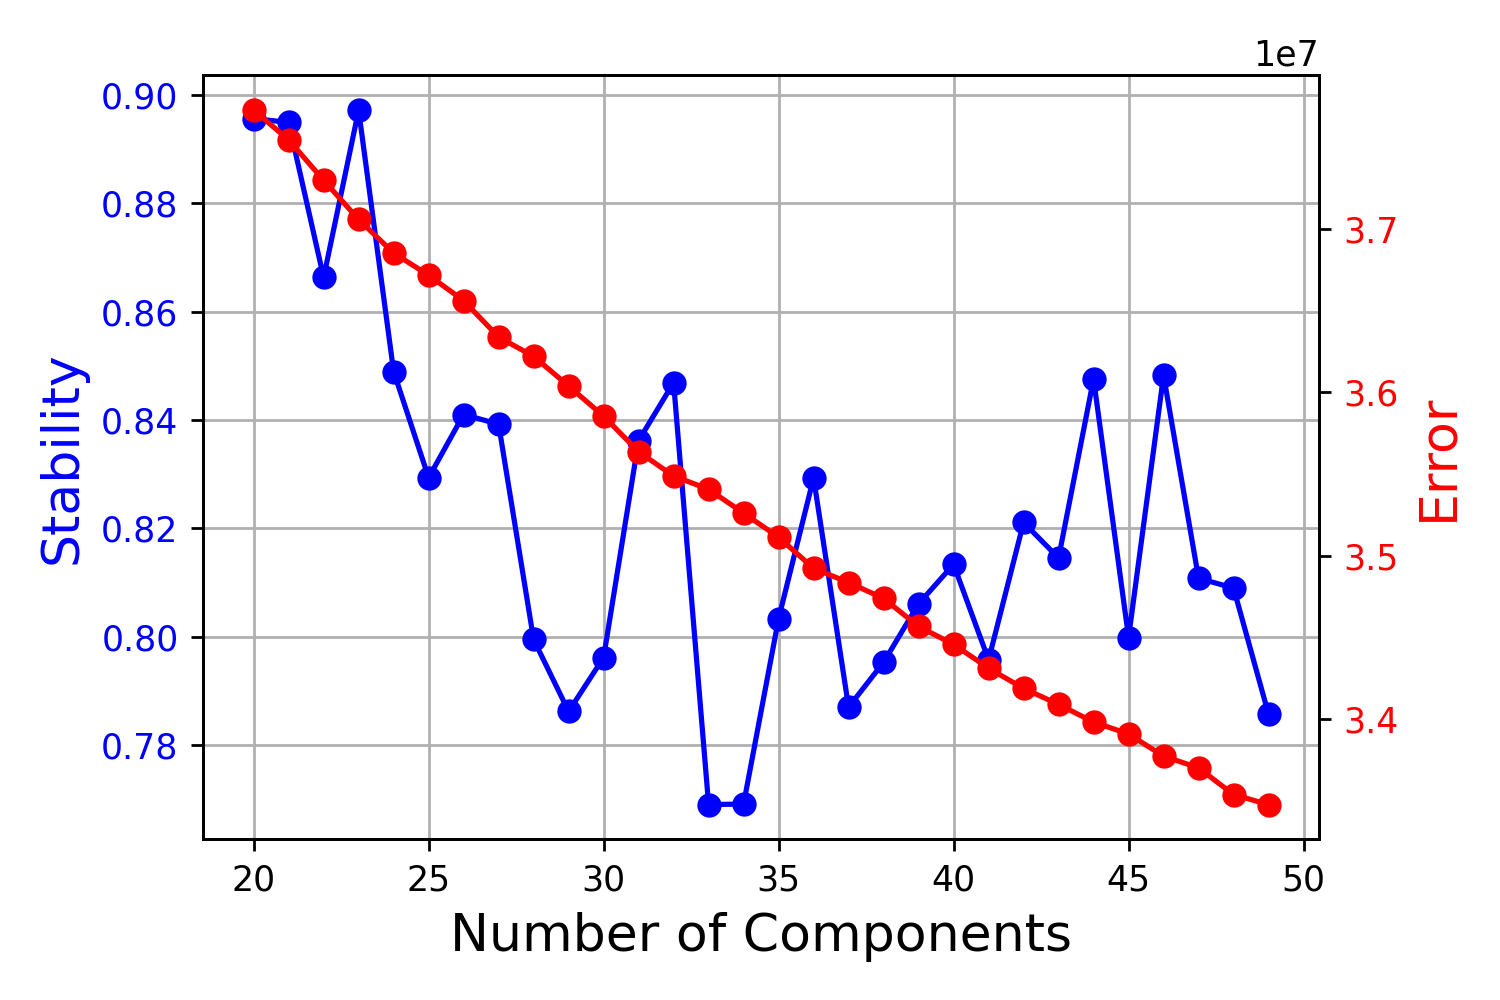

In [15]:
# step3 k selection
worker_index = ' '.join([str(x) for x in range(1)])
kselect_plot_cmd = '/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

from IPython.display import Image
Image(filename = "/home/wyh/scdata/combined_data/Epithelial/NMFV2_new/%s/%s.k_selection.png"%(run_name, run_name), width=1000, height=1000)

In [15]:
# step4 consenseus
for K in range(20,50):
    selected_K = K
    density_threshold = 2
    consensus_cmd = '/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
    print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
    !{consensus_cmd}

    density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
    basedir = "/home/wyh/scdata/combined_data/Epithelial"
output_directory = basedir+"/NMFV2/"(filename = "./NMFV2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)

Consensus command for K=20:
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py consensus --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2/ --name Epithelial_adeno --local-density-threshold 2.00 --components 20 --show-clustering


<>:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?


(28162, 2000)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/wyh/scdata/combined_data/Epithelial/cnmf.py:570: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (np.array(tpm.X.todense()) - tpm_stats['__mean'].values) / tpm_stats['__std'].values
(31906, 28162)
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
Consensus command for K=21:
/home/wyh/anaconda3/envs/wuyh_py38/bin/python /home/wyh/scdata/combined_data/Epithelial/cnmf.py consensus --output-dir /home/wyh/scdata/combined_data/Epithelial/NMFV2/ --name Epithelial_adeno --local-density-threshold 2.00 --components 21 --show-clustering
(28162, 20

/tmp/ipykernel_1516321/51182912.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  output_directory = basedir+"/NMFV2/"(filename = "./NMFV2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)
/tmp/ipykernel_1516321/51182912.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  output_directory = basedir+"/NMFV2/"(filename = "./NMFV2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)
/tmp/ipykernel_1516321/51182912.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  output_directory = basedir+"/NMFV2/"(filename = "./NMFV2/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)


TypeError: 'str' object is not callable

In [114]:
# step5 result show
selected_K = 26
density_threshold = 2.00
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
run_name = "Epithelial_adeno"
usage = pd.read_csv('./NMFV2/%s/%s.usages.k_%d.dt_%s.consensus.txt' % (run_name, run_name, selected_K, density_threshold_str),
                    sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)


In [115]:
adata_adeno_sample = sc.read_h5ad("./NMFV2/adata_adeno_p_sample.h5ad")
adata_adeno_sample.obs = pd.merge(left=adata_adeno_sample.obs, right=usage_norm, how='left', left_index=True, right_index=True)
sc.pl.umap(adata_adeno_sample, color=list(usage_norm.columns) , ncols=3, vmin=0, vmax=1, save="tumor_%d.png"%selected_K)

In [19]:
for K in range(20,50):
    selected_K = K
    density_threshold = 2.00
    run_name = "Epithelial_adeno"
    density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
    gene_scores = pd.read_csv('./NMFV2/%s/%s.gene_spectra_score.k_%d.dt_%s.txt' % (run_name, run_name, selected_K, density_threshold_str),
                        sep='\t', index_col=0).T

    ## Obtain the top 100 genes for each GEP in sorted order and combine them into a single dataframe
    top_genes = []
    ngenes = 100
    for gep in gene_scores.columns:
        top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))

    top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
    top_genes
    top_genes.to_csv("./NMFV2/robustness_analysis/top_genes_GM"+str(selected_K)+".csv")

In [5]:
selected_K = 23
density_threshold = 2.00
run_name = "Epithelial_adeno"
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
gene_scores = pd.read_csv('./NMFV2/%s/%s.gene_spectra_score.k_%d.dt_%s.txt' % (run_name, run_name, selected_K, density_threshold_str),
                sep='\t', index_col=0).T
gene_scores.dropna(inplace =True)
top_genes = []
ngenes = 200
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))

top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,LEFTY1,HGF,TOP2A,TF,HEXIM1,FMR1NB,FCER1G,NME1,C14orf132,PLAT,...,CRP,TESPA1,LMO7,LINC01915,DPEP1,COMP,FAAP24,CST6,MT1B,CALML3
1,PLA2G10,GACAT2,ASPM,APOA1,PIK3R3,PAGE5,SRGN,NME2,C16orf89,CP,...,APCS,PPP1R1A,CEACAM6,RASSF8,FABP1,TTYH1,CYP2S1,MIR205HG,MT1A,DEFA5
2,CLDN10,SYNE1,CENPF,ALB,PPP1R10,SPANXB1,RGS1,UQCRH,CRABP1,GIHCG,...,PLAC4,MAGEA11,CEACAM5,SLC35E3,C17orf78,ACE2,RAX,PLAU,MT1H,FGF3
3,IFI6,FST,TPX2,CTAG2,NEAT1,PAGE2,CCL4,TXN,FOLH1,RARRES1,...,CRISP3,S100A1,GPRC5A,CPM,PHGR1,ITIH2,DMBT1,FSTL1,MT1M,NKD1
4,TNFSF10,THSD7A,NUSAP1,DHRS2,AC023157.3,STARD3,C1QA,PSMB3,SLC26A3,TSPAN31,...,SULT1C4,NAPSA,ADGRF1,NUP107,PRAP1,SFRP5,GPATCH1,IGFBP7,THEMIS,CPLX2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,LPAR6,AC006145.1,GINS1,GC,FAM118A,RBPJ,TRAF3IP3,ENY2,TRPV6,ITGB3,...,HIF1A,ASB9,CLTB,DEPDC1B,EPHB1,KALRN,FRMD1,PLXND1,C5orf66-AS1,NCL
196,KDELR3,CXADR,HP1BP3,EI24,TRIM52,VKORC1,CYTOR,NDUFB1,ARF4,DMRTA1,...,IFI6,BLVRB,DSG2,UFC1,PRSS8,RACK1,ZIC1,KRT6A,AL589740.1,AC080112.4
197,SMIM6,NTN4,TRIP13,ATP6V0E2,WDR60,TFPI2,AATF,AURKAIP1,S100A13,CTSL,...,ERVV-2,ALDH1A1,CDH1,ASPH,NBL1,FGL1,H3F3A,PODNL1,LINC00940,SSB
198,MPC2,LYPD1,RDM1,AC006058.3,ARHGEF5,CASC15,FN1,MGST3,TIMP1,ST3GAL4,...,CHST4,AC019185.2,CAMK2N1,ARFGEF1,ARID5B,FUT4,PLEKHJ1,PLEC,PCDHB11,LEF1


## Figure: cluster cells by gene expression

In [ ]:
adata_adeno = sc.read_h5ad("./adata_adeno_P.h5ad")
ngenes = 100
K_range = [23]
for K in K_range:
    program_num = K

    top_genes = pd.read_csv("./NMFV2/top_genes_GM"+str(program_num)+".csv",index_col=0)
    top_genes = top_genes.iloc[range(ngenes),]
    top_genes.shape

    for iGM in range(top_genes.shape[1]):
        GM =list(top_genes.iloc[:,iGM])
        sc.tl.score_genes(adata_adeno,gene_list = GM,score_name = "score_GM"+str(iGM+1))

    score_module = adata_adeno.obs[["score_GM"+str(i+1) for i in range(top_genes.shape[1])]]
    score_module.to_csv("./gene_module/adeno_p/patient_GM_score_" + str(program_num) +"GM_"+str(ngenes)+"genes.csv")

/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.

In [ ]:
K_range = [23]
for K in K_range:
    program_num = K
    score = pd.read_csv("./gene_module/adeno_p/patient_GM_score_" + str(program_num) +"GM_"+str(ngenes)+"genes.csv",index_col = 0)
    for iGM in range(K):
        score_temp = score.loc[:,'score_GM'+str(iGM+1)]
        score.loc[:,'score_GM'+str(iGM+1)] = (score_temp-min(score_temp))/(max(score_temp)-min(score_temp))

    score.to_csv("./gene_module/adeno_p/normalize/patient_GM_score_" + str(program_num) +"GM_"+str(ngenes)+"genes.csv")

/home/wyh/anaconda3/envs/wuyh_py38/lib/python3.8/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


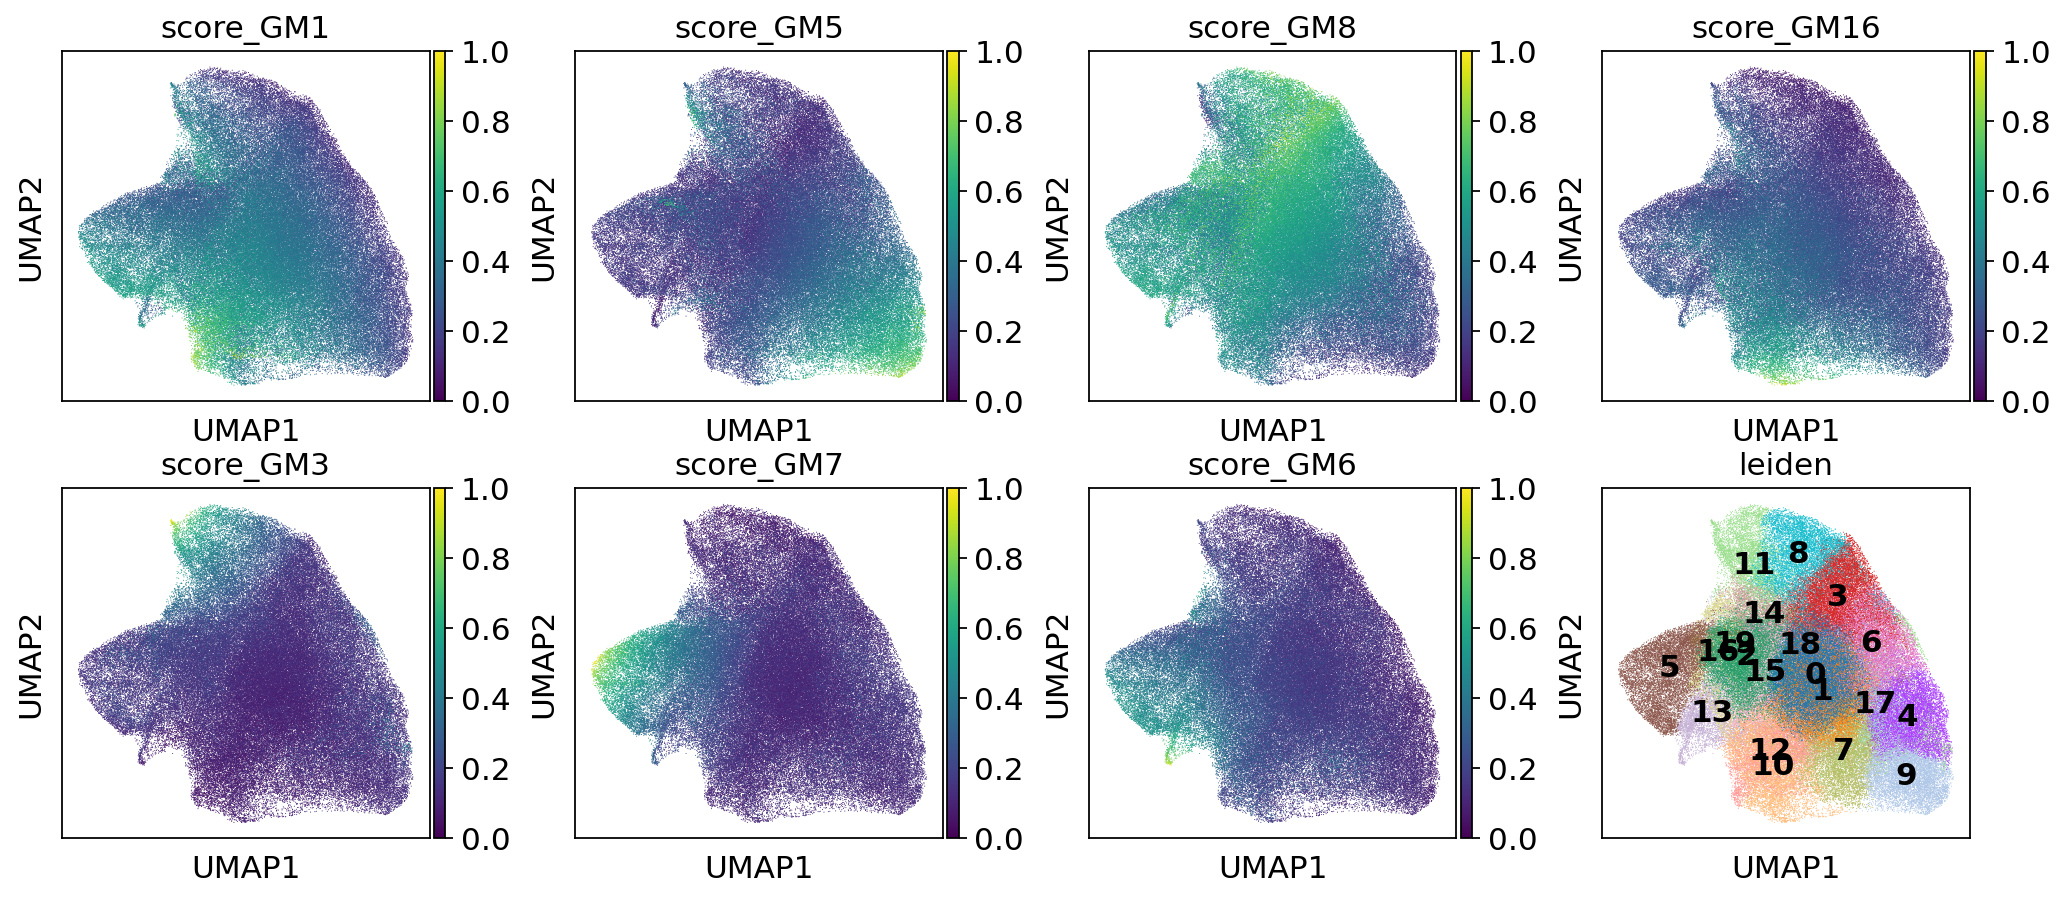

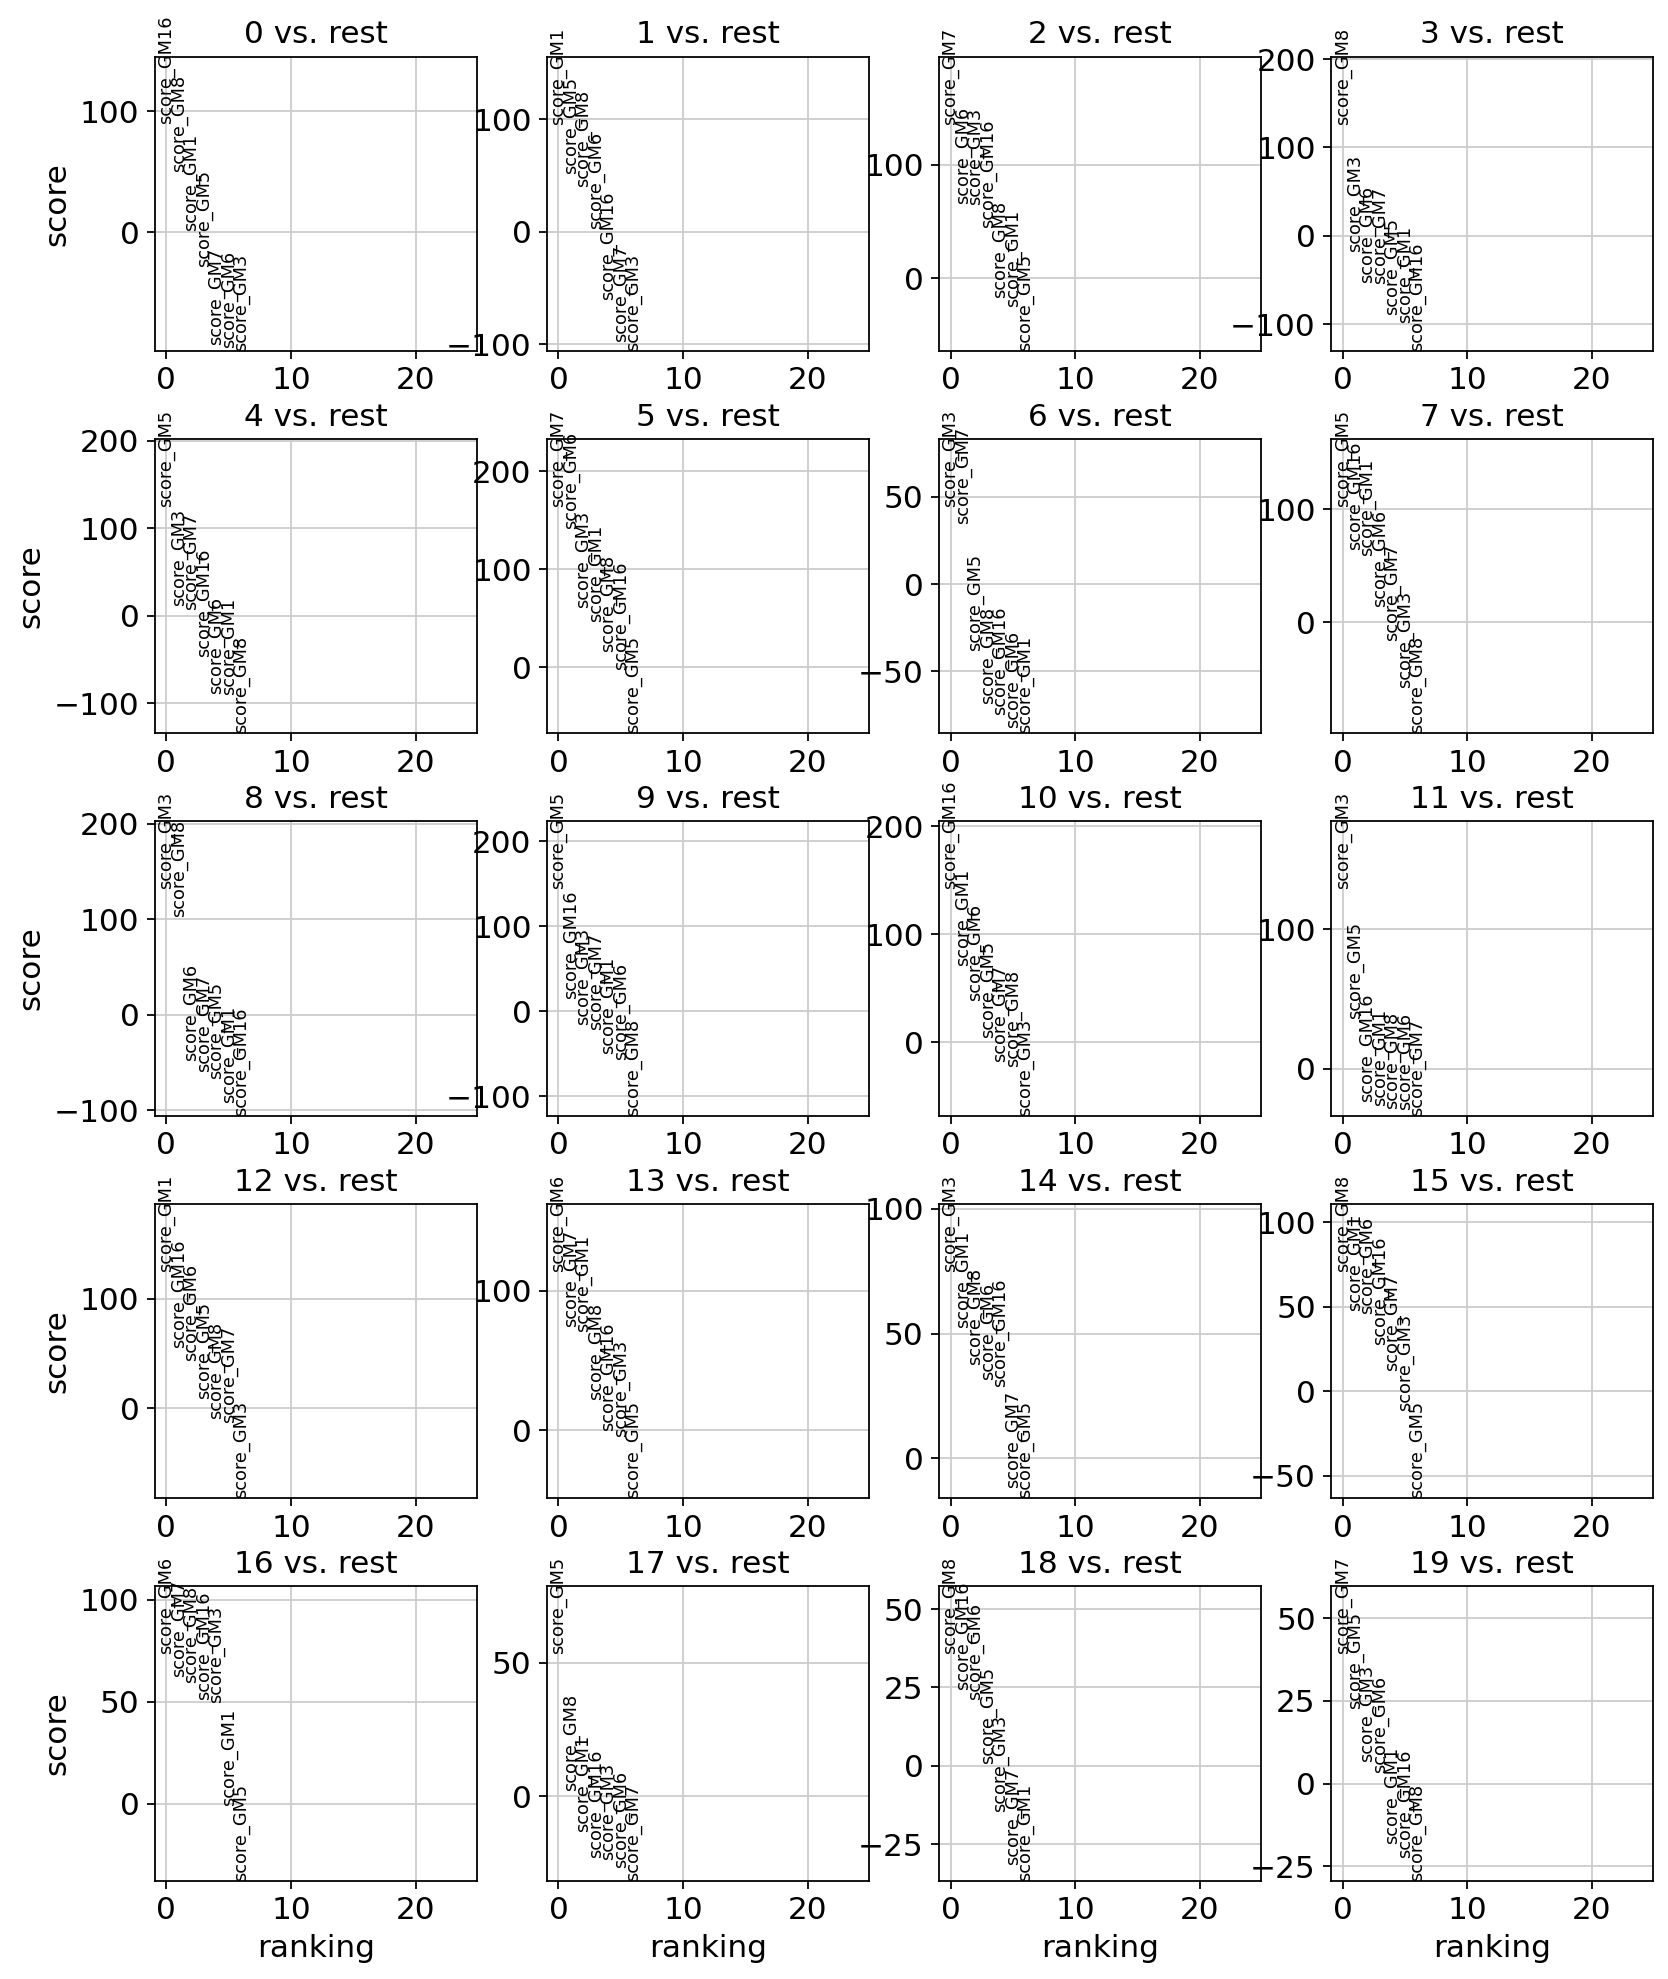

In [7]:
os.chdir("/home/wyh/scdata/combined_data/Epithelial/")
adata_adeno_p = sc.read_h5ad("./adata_adeno_P.h5ad")
ngenes = 100
K_range = [23]
for K in K_range:
    program_num = K
    score = pd.read_csv("./gene_module/adeno_p/normalize/patient_GM_score_" + str(program_num) +"GM_"+str(ngenes)+"genes.csv",index_col = 0)
    share_state = pd.read_csv("./gene_module/adeno_p/share_state/pvalue_patient_shared_state_"+str(program_num)+"GM_"+str(ngenes)+"genes.csv",index_col = 0).iloc[:,0]
    score = score.loc[:,["score_GM"+str(i) for i in share_state]]

    # 创建anndata对象
    n_obs = score.shape[0]
    # 生成观察时间
    obs = adata_adeno_p.obs

    # 设置特征名
    var_names = score.columns
    # 特征数量
    n_vars = len(var_names)
    # 特征注释数据框
    var = pd.DataFrame(index=var_names)
    # 生成数据矩阵
    X = score

    adata_GM = ad.AnnData(X, obs=obs, var=var, dtype='float')

    adata_GM.raw = adata_GM
    sc.pp.scale(adata_GM, max_value=10)
    sc.pp.neighbors(adata_GM)
    sc.tl.leiden(adata_GM)
    sc.tl.umap(adata_GM)
    adata_GM = adata_GM.raw.to_adata()

    plot_index = ["score_GM"+str(i) for i in share_state]
    plot_index.append("leiden")
    sc.pl.umap(adata_GM,color = plot_index,legend_loc='on data',save = "/clustering/GM_"+str(program_num)+".png")
    sc.tl.rank_genes_groups(adata_GM, 'leiden', method='wilcoxon')
    sc.pl.rank_genes_groups(adata_GM, n_genes=25, sharey=False)
    adata_GM.write("./gene_module/adeno_p/clustering/adata_GM"+str(program_num)+"genes"+str(ngenes)+".h5ad")

In [45]:
# 计算每一群的熵，防止某些群被某些病人主导,输出每一群熵的图
def test_entropy(label):
    a = Counter(label)
    a = list(a.values())
    ratio = [i/sum(a) for i in a]
    res= 0 
    for i in range(len(ratio)):
        if(ratio[i]!=0):
            res = res+ratio[i]*np.log2(ratio[i])
    return(-res)

## figure: define the state of each cell by gene module score

In [6]:
os.chdir("/home/wyh/scdata/combined_data/Epithelial/")
adata_adeno_p = sc.read_h5ad("./adata_adeno_P.h5ad")
ngenes = 100
K_range = [23]
for K in K_range:
    program_num = K
    score = pd.read_csv("./gene_module/adeno_p/patient_GM_score_" + str(program_num) +"GM_"+str(ngenes)+"genes.csv",index_col = 0)
    share_state = pd.read_csv("./gene_module/adeno_p/share_state/pvalue_patient_shared_state_"+str(program_num)+"GM_"+str(ngenes)+"genes.csv",index_col = 0).iloc[:,0]
    score = score.loc[:,["score_GM"+str(i) for i in share_state]]

In [7]:
column_name = score.columns
row_name = score.index

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [9]:
std_scaler = StandardScaler()

score_scaled = std_scaler.fit_transform(score.to_numpy())
score_scaled = pd.DataFrame(score_scaled, columns=column_name,index = row_name)

print("Scaled Dataset Using StandardScaler")
score_scaled.head()


Scaled Dataset Using StandardScaler


,score_GM1,score_GM5,score_GM8,score_GM16,score_GM3,score_GM7,score_GM6
barcodes,,,,,,,
GBC_035_P_CTGTACCCATGCGGTC,0.799675,2.294183,-1.234487,-0.064838,-0.225643,0.809889,0.257210
GBC_043_P_AATGGCTAGAATGTTG,-0.759310,0.670744,-0.594269,-0.770976,0.031554,1.174968,-0.687320
GBC_043_P_AATTTCCTCGGAATGG,-0.850191,0.028132,-0.829426,-0.627933,0.183901,1.752425,-0.158208
GBC_043_P_ACGTCCTCACTGGACC,-0.546542,-0.127271,-1.351146,-0.324437,0.193161,1.493351,-0.753646
GBC_043_P_ATATCCTTCGCGGTAC,-0.311904,0.131845,-1.407852,-0.459832,0.075560,2.310754,0.321991


In [10]:
adata_adeno_p.obs = pd.concat([adata_adeno_p.obs, score_scaled], axis=1)

In [11]:
GM_cell = score_scaled.idxmax(1)

In [12]:
adata_adeno_p.obs['cell_state'] = [i.replace("score_","") for i in GM_cell]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 23 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'G', 'M', 'P', 'U', 'a', 'c', 'e', 'eight', 'five', 'l', 'nonmarkingreturn', 'one', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 24, 25, 26, 27, 36, 42, 48, 51, 56, 66, 68, 70, 72, 79, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 23 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'G', 'M', 'P', 'U', 'a', 'c', 'e', 'eight', 'five', 'l', '

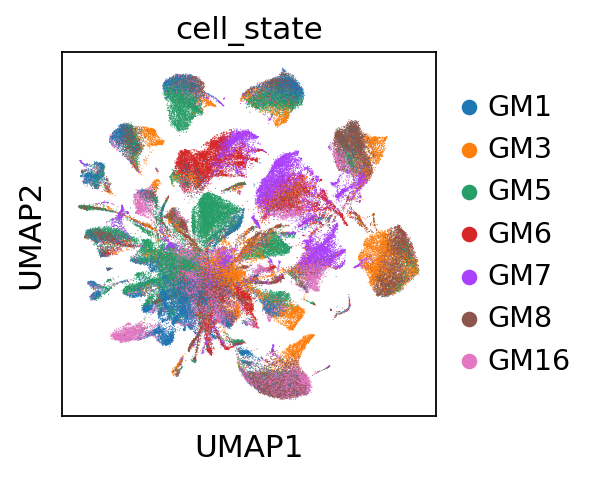

In [20]:
sc.pl.umap(adata_adeno_p,color = 'cell_state',save = "cell_stateV2.pdf")

## figure: heterogeneity of patient

In [15]:
adata_adeno_p.obs = adata_adeno_p.obs.iloc[:,range(128)]

In [78]:
adata_adeno_p.write("./adata_adeno_P.h5ad")

In [17]:
adata_adeno_p = sc.read_h5ad("./adata_adeno_P.h5ad")

In [16]:
adata_adeno_p.obs.to_csv("./adata_adeno_P.obs_df.csv")

In [19]:
def estimateDiversity(sample,adata,nPCs = 40):
    adata_sample = adata[adata.obs['orig.ident']==sample,]
    pca = adata_sample.obsm['X_pca']
    pca = pca[:,range(nPCs)]
    pca_mean = np.mean(pca,axis = 0)
    pca_sd = np.var(pca,axis = 0)
    pca = pca[([pca[:,0]<=(pca_mean[0]+3*pca_sd[0])] and [pca[:,0]>=(pca_mean[0]-3*pca_sd[0])])[0],:]
    pca = pca[([pca[:,1]<=(pca_mean[1]+3*pca_sd[1])] and [pca[:,1]>=(pca_mean[1]-3*pca_sd[1])])[0],:]
    pca = pca[([pca[:,2]<=(pca_mean[2]+3*pca_sd[2])] and [pca[:,2]>=(pca_mean[2]-3*pca_sd[2])])[0],:]
    pca_mean = np.mean(pca,axis = 0)
    diversity_score = np.mean(np.sqrt(np.sum((pca-pca_mean)**2,axis = 1))).tolist()
    return(diversity_score)

In [24]:
nPC = 20
dirversity_score_all = []
for ipatient in np.unique(adata_adeno_p.obs['orig.ident']):
    dirversity_score_all.append(estimateDiversity(ipatient,adata_adeno_p,nPCs = nPC))
diversity_score =  pd.DataFrame(index = np.unique(adata_adeno_p.obs['orig.ident']))
diversity_score['score'] = dirversity_score_all
diversity_score.to_csv("./group_compare/adeno_p/diversity/diversity_score_PC"+str(nPC)+".csv")    

## figure: top gene expression within each gene module 

In [67]:
gene_GM = pd.read_csv("./NMFV2/top_genes_23.csv",index_col = 0)

In [69]:
sc.pp.scale(adata_adeno_p, max_value=10)

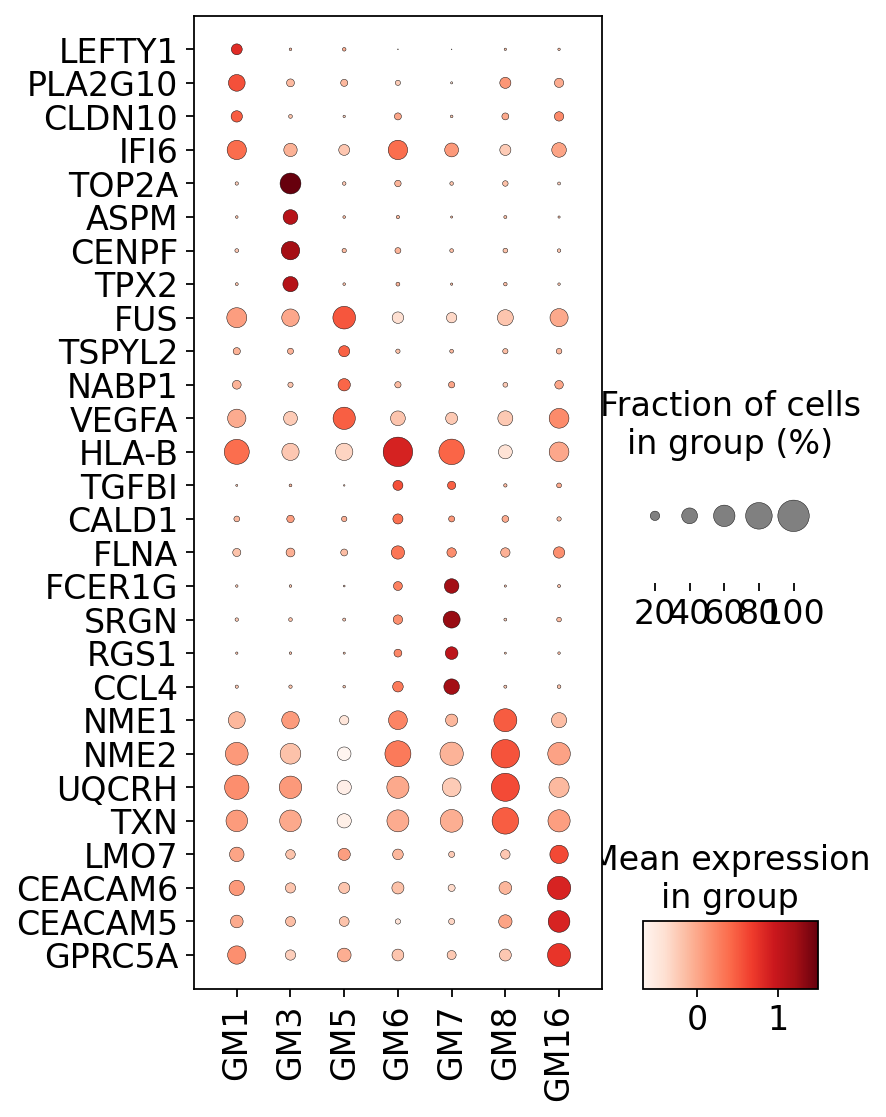

In [117]:
from matplotlib import rcParams
from matplotlib import rcParams
config = {
    "font.family":'sans-serif',
    "font.size": 18,
    "mathtext.fontset":'stix',
    "font.serif": ['MS Arial'],
}
rcParams.update(config)

# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
sc.pl.dotplot(adata_adeno_p_scale, np.array(a.T).flatten().tolist(), groupby='cell_state',save = 'GM_gene_heatmap_5_8.pdf',
              figsize=[5,8],swap_axes=True,edgecolors = 'none',linewidths = 0)